In [1]:
#Import relevant packages
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from keras.utils import to_categorical
import keras
import keras_tuner
import sklearn
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Input
from keras import backend as K
from keras.callbacks import EarlyStopping


### Initializations

In [3]:
#Load in filepaths and set global seed
cardboard_files = glob.glob("Cardboard/*.s2p")
metal_files = glob.glob("Metal/*.s2p")
plastic_files = glob.glob("Plastic/*.s2p")
keras.utils.set_random_seed(42)

In [4]:
#Count number of scans taken from each unqiue object for labling purposes
def count_scans(filenames, classes):
    counts = []
    for c in classes:
        for i in range(34):
            x = sum(1 for name in filenames if name.__contains__(f'{c}o{i}s'))
            if x != 0:
                counts.append(x)
    return counts

In [5]:
c_scans=count_scans(cardboard_files, ["c"])

[9, 17, 13, 22, 15, 10, 9, 14, 11, 16, 5, 12, 11, 11, 15, 20, 13, 12, 11, 10, 9, 10, 8, 9, 15, 15, 10, 14, 12, 6]
30
12.133333333333333


11.5

In [6]:
p_scans=count_scans(plastic_files, ["p"])

[10, 7, 11, 17, 14, 10, 10, 11, 10, 8, 15, 11, 11, 15, 11, 11, 11, 8, 10, 13, 10, 13, 16, 15, 7, 10, 12, 14, 11, 11, 16, 9, 7]
33
11.363636363636363


11.0

In [7]:
m_scans=count_scans(metal_files, ["m"])

[14, 14, 7, 10, 11, 7, 15, 12, 10, 12, 10, 10, 10, 12, 13, 9, 12, 12, 11, 12, 11, 12, 12, 13, 6, 11, 12, 8, 12, 8, 10, 12, 11, 12]
34
10.970588235294118


11.5

In [8]:
#A method for creating a dataset from a list of filepaths
def dataset(filepaths):
    dataset = np.empty((len(filepaths), 101, 5))
    for index, file in enumerate(filepaths):
        data = np.loadtxt(file, skiprows = 1, usecols = (0,1,2,3,4))
        dataset[index] = data
    return dataset

In [9]:
#Create a combined dataset and a total list of scans per object for unique object tracking
files = cardboard_files + metal_files + plastic_files
print(len(files))
scans = count_scans(files, ["c", "m", "p"])
data = dataset(files)
#remove the measurement frequency column
data = np.delete(data, 0, 2)
data.shape

1112


(1112, 101, 4)

In [10]:
#Create vector of label data for individual scan labelling
c_obj_classes = np.zeros([len(c_scans), 1])
m_obj_classes = np.ones([len(m_scans), 1])
p_obj_classes = np.ones([len(p_scans), 1])
p_obj_classes[p_obj_classes == 1] = 2
obj_classes = np.concatenate((c_obj_classes, m_obj_classes, p_obj_classes))

### Hyperparameter optimization

In [12]:
#create a training data and matching ground truth vector pair
#Indices contains the vector of indices given by sklearn train/test split
def create_Xy(data, indices, scans, classes, files):
    
    X = np.empty((0, 101, 4))
    y = np.empty((1))
    
    for item in indices:
        #Check the class vector against object index to see which class the object belongs to and set relevant information
        if classes[item] == 0:
            c = "c"
            i = item
        
        elif classes[item] == 1:
            c = "m"
            i = item - 30

        else:
            c = "p"
            i = item - 64

        #find the corresponding data file and add to dataset. Add the label of the item to ground truth vector
        for name, file in zip(files, data):
            if name.__contains__(f'{c}o{i}s'):
                X = np.vstack([X, np.expand_dims(file, axis=0)])
                y = np.vstack([y, classes[item]])

    #remove the initial value from the ground truth vector that is created during initialization
    y = np.delete(y, (0), axis=0)
    
    #shuffle the dataset
    r = np.random.permutation(len(y))
    X, y = X[r], y[r]

    #turn the ground truth vector into onehot encoding
    y = to_categorical(y, num_classes=3)
    
    return X, y

In [13]:
#create the dataset by splitting based on item
#Dataset is created in this manner to ensure scans from one item are only present in a single set (train, test, val) at a time
def item_wise_split(scans, classes, filenames, dataset, seed):

    #create a running index of the objects in the dataset
    item_idx = list(range(len(scans)))
    #split object indices into train and test set 
    train, test = train_test_split(item_idx, test_size = 0.1, random_state = seed, stratify = classes)
    #plit train set indices further into train and val set
    train, val = train_test_split(train, test_size = 0.1, random_state = seed, stratify = classes[train])

    #create train, test and validation sets using create_Xy
    X_train, y_train = create_Xy(dataset, train, scans, classes, filenames)
    
    X_test, y_test = create_Xy(dataset, test, scans, classes, filenames)
    
    X_val, y_val = create_Xy(dataset, val, scans, classes, filenames)
    
    return (X_train, y_train), (X_test, y_test), (X_val, y_val)



In [14]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = item_wise_split(scans, obj_classes, files, data, 2)

### Trial 1
Test four different general layer structures and two optimizers to find best performing combination.

In [16]:
#Generate models
def build_model(hp):
    input_shape = (101, 4)
    m_type = hp.Int('type', min_value=1, max_value=4)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    if m_type == 1:
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))

    if m_type == 2:
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))

    if m_type == 3:
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))

    if m_type == 4:
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [18]:
#Create GridSearch object to run hyperparameter optimization
from keras_tuner.tuners import GridSearch

Gtuner = GridSearch(
    build_model,
    objective='val_accuracy',
    executions_per_trial=1,
    directory = 'mu_trial1',
    project_name = 'mu_trial1'
)

Reloading Tuner from mu_trial1\mu_trial1\tuner0.json


In [19]:
Gtuner.search(X_train, y_train, epochs=400, validation_data=(X_val, y_val), verbose = 2)

In [20]:
#Show the 10 best performing models based on validation set accuracy
Gtuner.results_summary()

Results summary
Results in mu_trial1\mu_trial1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0005 summary
Hyperparameters:
type: 3
optimizer: rmsprop
Score: 0.9887640476226807

Trial 0003 summary
Hyperparameters:
type: 2
optimizer: rmsprop
Score: 0.9775280952453613

Trial 0007 summary
Hyperparameters:
type: 4
optimizer: rmsprop
Score: 0.9775280952453613

Trial 0001 summary
Hyperparameters:
type: 1
optimizer: rmsprop
Score: 0.9775280952453613

Trial 0004 summary
Hyperparameters:
type: 3
optimizer: adam
Score: 0.966292142868042

Trial 0002 summary
Hyperparameters:
type: 2
optimizer: adam
Score: 0.966292142868042

Trial 0000 summary
Hyperparameters:
type: 1
optimizer: adam
Score: 0.966292142868042

Trial 0006 summary
Hyperparameters:
type: 4
optimizer: adam
Score: 0.966292142868042


In [21]:
best_model = Gtuner.get_best_models(num_models=1)[0]
best_model.summary()

C:\Users\joona\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 404)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,603 (381.26 KB)

 Trainable params: 97,603 (381.26 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
#find the best performing model accuracy on the test set for model selection purposes
y_test_vals = np.argmax(y_test, axis=-1)
predictions = best_model.predict(X_test, verbose=0)
predictions = np.argmax(predictions, axis=-1)

scores = best_model.evaluate(X_test, y_test, verbose=0)
print("Test set accuracy:", scores[1])

Test set accuracy: 0.9406779408454895


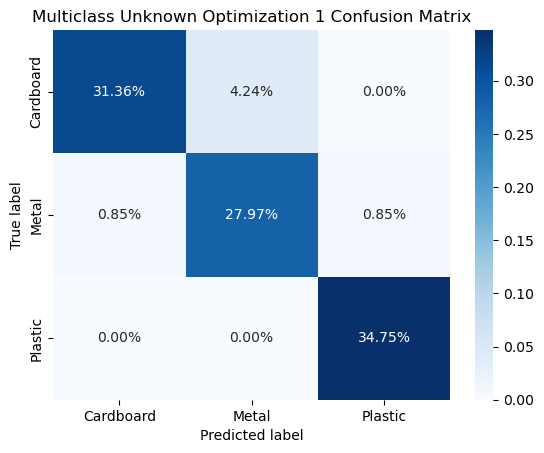

In [23]:
categories = ["Cardboard","Metal","Plastic"]
cf_matrix = sklearn.metrics.confusion_matrix(y_test_vals, predictions)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels=categories, yticklabels=categories,  
            fmt='.2%', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Multiclass Unknown Optimization 1 Confusion Matrix')
plt.savefig('Graphs/Multiclass_Unknown_Trial1.png')

### Trial 2
Fine tune the number of layers in the best performing layer structure and optimizer combination for model selection purposes.

In [25]:
def build_model_2(hp):
    input_shape = (101, 4)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    for i in range(hp.Int('num_large_layers', min_value=0, max_value=1)):
        model.add(Dense(256, activation = 'relu'))
    for i in range(hp.Int('num_mid_layers', min_value=1, max_value=3)):
        model.add(Dense(128, activation = 'relu'))
    for i in range(hp.Int('num_small_layers', min_value=3, max_value=6)):
        model.add(Dense(64, activation = 'relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [26]:
from keras_tuner.tuners import GridSearch

Gtuner = GridSearch(
    build_model_2,
    objective='val_accuracy',
    executions_per_trial=1,
    directory = 'mu_trial2',
    project_name = 'mu_trial2'
)

Reloading Tuner from mu_trial2\mu_trial2\tuner0.json


In [27]:
Gtuner.search(X_train, y_train, epochs=500, validation_data=(X_val, y_val), verbose = 2)

In [28]:
Gtuner.results_summary()

Results summary
Results in mu_trial2\mu_trial2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0015 summary
Hyperparameters:
num_large_layers: 1
num_mid_layers: 1
num_small_layers: 6
Score: 1.0

Trial 0006 summary
Hyperparameters:
num_large_layers: 0
num_mid_layers: 2
num_small_layers: 5
Score: 0.9887640476226807

Trial 0023 summary
Hyperparameters:
num_large_layers: 1
num_mid_layers: 3
num_small_layers: 6
Score: 0.9887640476226807

Trial 0001 summary
Hyperparameters:
num_large_layers: 0
num_mid_layers: 1
num_small_layers: 4
Score: 0.9887640476226807

Trial 0016 summary
Hyperparameters:
num_large_layers: 1
num_mid_layers: 2
num_small_layers: 3
Score: 0.9887640476226807

Trial 0021 summary
Hyperparameters:
num_large_layers: 1
num_mid_layers: 3
num_small_layers: 4
Score: 0.9887640476226807

Trial 0007 summary
Hyperparameters:
num_large_layers: 0
num_mid_layers: 2
num_small_layers: 6
Score: 0.9887640476226807

Trial 0022 summary
Hyperparameters:
num_large_lay

In [29]:
best_model = Gtuner.get_best_models(num_models=1)[0]
best_model.summary()

C:\Users\joona\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 404)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       103,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,827 (647.76 KB)

 Trainable params: 165,827 (647.76 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
y_test_vals = np.argmax(y_test, axis=-1)
predictions = best_model.predict(X_test, verbose=0)
predictions = np.argmax(predictions, axis=-1)

scores = best_model.evaluate(X_test, y_test, verbose=0)
print("Test set accuracy:", scores[1])
#labels = ["True Neg","False Pos","False Neg","True Pos"]

Test set accuracy: 0.8898305296897888


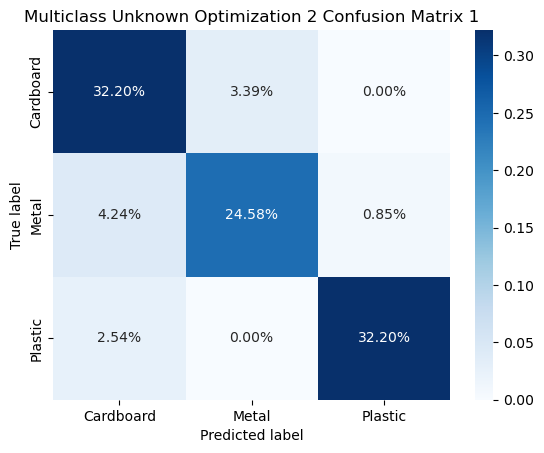

In [31]:
categories = ["Cardboard","Metal","Plastic"]
cf_matrix = sklearn.metrics.confusion_matrix(y_test_vals, predictions)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels=categories, yticklabels=categories,  
            fmt='.2%', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Multiclass Unknown Optimization 2 Confusion Matrix 1')
plt.savefig('Graphs/Multiclass_Unknown_Trial2_1.png')

In [32]:
#Test the second best model from trial 2 due to best performing model being worse than the best performing trial 1 model on the test set
best_model = Gtuner.get_best_models(num_models=2)[1]
predictions = best_model.predict(X_test, verbose=0)
predictions = np.argmax(predictions, axis=-1)

scores = best_model.evaluate(X_test, y_test, verbose=0)
print("Test set accuracy:", scores[1])

C:\Users\joona\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\joona\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Test set accuracy: 0.9152542352676392


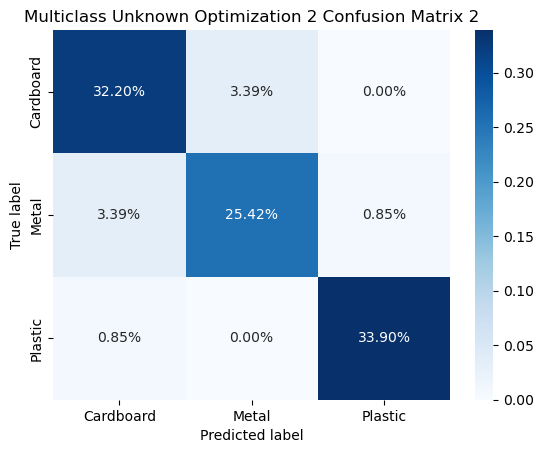

In [33]:
categories = ["Cardboard","Metal","Plastic"]
cf_matrix = sklearn.metrics.confusion_matrix(y_test_vals, predictions)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels=categories, yticklabels=categories,  
            fmt='.2%', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Multiclass Unknown Optimization 2 Confusion Matrix 2')
plt.savefig('Graphs/Multiclass_Unknown_Trial2_2.png')

### K-fold validation of previous models
Performance evaluation of the best performing trial model over 10-fold cross-validation. Validation set is created in order to optimize model training length. Model performance is presented using accuracy, precision, recall and the F1-score. An aggregate confusion matrix of model performance across each fold is also presented.

In [35]:
#Seeded layer parameter initializer for reproducibility
initializer = keras.initializers.GlorotUniform(seed=42)

In [36]:
def build_k_fold_model():
    input_shape = (101, 4)
    nb_classes = 3

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu', kernel_initializer = initializer))
    model.add(Dense(128, activation = 'relu', kernel_initializer = initializer))
    model.add(Dense(64, activation = 'relu', kernel_initializer = initializer))
    model.add(Dense(64, activation = 'relu', kernel_initializer = initializer))
    model.add(Dense(64, activation = 'relu', kernel_initializer = initializer))
    model.add(Dense(64, activation = 'relu', kernel_initializer = initializer))
    model.add(Dense(64, activation = 'relu', kernel_initializer = initializer))
    model.add(Dense(64, activation = 'relu', kernel_initializer = initializer))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [37]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="model.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [38]:
accuracy_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_per_fold = []
cf_matrices = []
objects = list(range(len(scans)))
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for fold, (train, test) in enumerate(skf.split(objects, obj_classes)):
    print(f'Fold {fold + 1}')
    
    train, val = train_test_split(train, test_size = 0.1, random_state = 2, stratify=obj_classes[train])
    
    X_train, y_train = create_Xy(data, train, scans, obj_classes, files)
    
    X_val, y_val = create_Xy(data, val, scans, obj_classes, files)
    
    X_test, y_test = create_Xy(data, test, scans, obj_classes, files)

    model = build_k_fold_model()
    
    model.fit(X_train, y_train,
              epochs=500,
              batch_size=128,
              validation_data=(X_val, y_val),
              callbacks = [model_checkpoint_callback],
              verbose=0)

    
    model = keras.models.load_model("model.keras")

    predictions = np.argmax(model.predict(X_test), axis=1)
    accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)

    values = precision_recall_fscore_support(np.argmax(y_test, axis = 1), predictions, average='macro')
    cf_matrix = sklearn.metrics.confusion_matrix(np.argmax(y_test, axis = 1), predictions)


    accuracy_per_fold.append(accuracy)
    precision_per_fold.append(values[0])
    recall_per_fold.append(values[1])
    f1_per_fold.append(values[2])
    cf_matrices.append(cf_matrix)
    
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {values[0] * 100:.2f}%')
    print(f'Recall: {values[1] * 100:.2f}%')
    print(f'F1-score: {values[2]:.4f}')

average_accuracy = np.mean(accuracy_per_fold)
average_precision = np.mean(precision_per_fold)
average_recall = np.mean(recall_per_fold)
average_f1 = np.mean(f1_per_fold)
print(f'\nAverage Accuracy Across {10} Folds: {average_accuracy * 100:.2f}%')
print(f'\nAverage Precision Across {10} Folds: {average_precision * 100:.2f}%')
print(f'\nAverage Recall Across {10} Folds: {average_recall * 100:.2f}%')
print(f'\nAverage F1-score Across {10} Folds: {average_f1:.4f}')

Fold 1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Accuracy: 84.07%
Precision: 83.55%
Recall: 82.75%
F1-score: 0.8257
Fold 2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Accuracy: 94.64%
Precision: 95.00%
Recall: 93.75%
F1-score: 0.9385
Fold 3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Accuracy: 91.27%
Precision: 93.33%
Recall: 90.09%
F1-score: 0.9048
Fold 4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Accuracy: 56.25%
Precision: 57.62%
Recall: 55.62%
F1-score: 0.5618
Fold 5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Accuracy: 79.83%
Precision: 82.08%
Recall: 80.32%
F1-score: 0.8082
Fold 6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Accuracy: 76.70%
Precision: 76.25%
Recall: 70.32%
F1-score: 0.6945
Fold 7
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Accuracy: 97.78%
Precision: 97.44%
Recall: 98.08%
F1-score: 0.9768
Fold 8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Accuracy: 76.00%
Precision: 82.04%
Recall: 78.13%
F1-score: 0.7634
Fold 9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Accuracy: 95.40%
Precision: 96.19%
Recall: 95.70%
F1-score

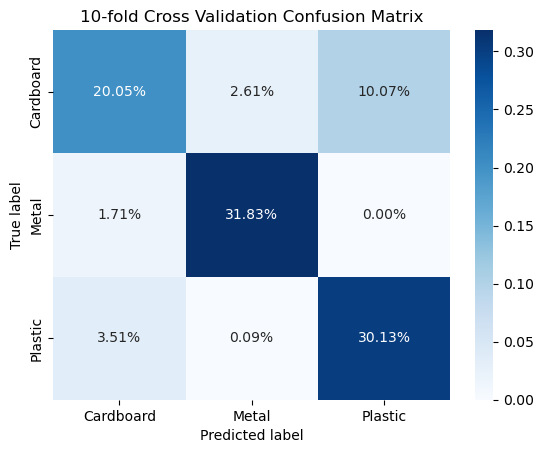

In [39]:
av_cf = sum(cf_matrices)
sns.heatmap(av_cf/np.sum(av_cf), annot=True, xticklabels=categories, yticklabels=categories,  
            fmt='.2%', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('10-fold Cross Validation Confusion Matrix')
plt.savefig('Graphs/Multiclass_Unknown_k-fold.png')